# Trabajo Nº1 – Clasificación de Perros y Gatos con CNN y Transfer Learning

In [27]:
# Añade aquí los import que utilices en tu código
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import pandas as pd

from sklearn.model_selection import train_test_split # para hacer la división de los datos
import matplotlib.image as mpimg # para ver las imágenes

# para establecer el CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import RMSprop # optimizador

from tensorflow.keras.preprocessing.image import ImageDataGenerator # para hacer el data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # para el early stopping

from tensorflow.keras.preprocessing import image # para procesar a Guadalupe

# modelos para el TTL
from tensorflow.keras.applications import VGG16

plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(33)
tf.random.set_seed(33)

## Carga de Imágenes

Se cargan exactamente **1000 imágenes de cada clase** desde la carpeta `Cats_Dogs`, asumiendo esta estructura:

```text
Cats_Dogs/
├─ cat/
│  ├─ 0.jpg
│  ├─ ...
├─ dog/
│  ├─ 0.jpg
│  ├─ ...
```

Preprocesamiento:
- Redimensionado a `224×224` píxeles (puedes cambiar `IMG_SIZE` si lo justificas).
- Conversión a RGB.

Las etiquetas se almacenan como enteros:
- `0` → gato  
- `1` → perro

In [28]:
# Configuración de rutas y parámetros
DATASET_DIR = "Cats_Dogs"  # Cambia si usas otra ruta
CATEGORIES = ["cat", "dog"]
IMG_SIZE = (224, 224) # reescalado de las imagenes

X = [] # lista de matrices rgb de imagenes
y = [] # lista de etiquetas gato (0) o perro (1)

# Descomprimir el dataset
if not os.path.exists(DATASET_DIR):
    !unzip -q Cats_Dogs.zip
    
# Cargar imágenes y etiquetas
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, category)
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            X.append(np.array(img))
            y.append(label)
        except Exception as e:
            print("Error al cargar:", img_path, e)

# Conversión a arrays
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int32")

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (2000, 224, 224, 3)
Forma de y: (2000,)


## Ver imágenes del dataset:

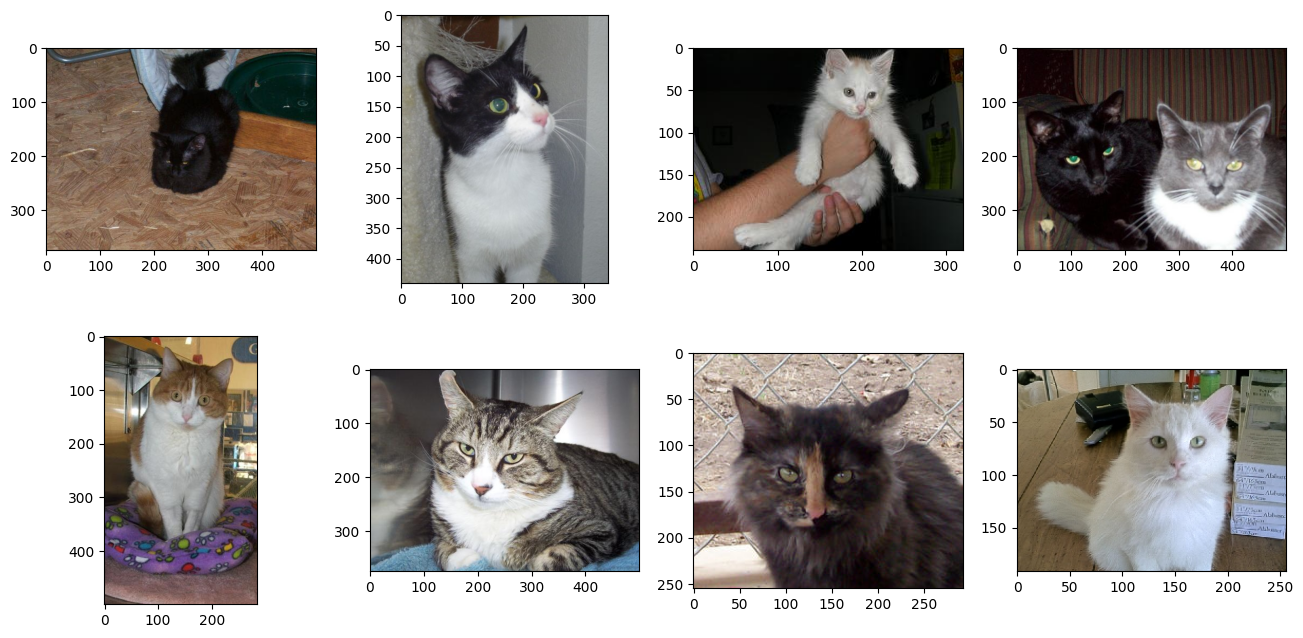

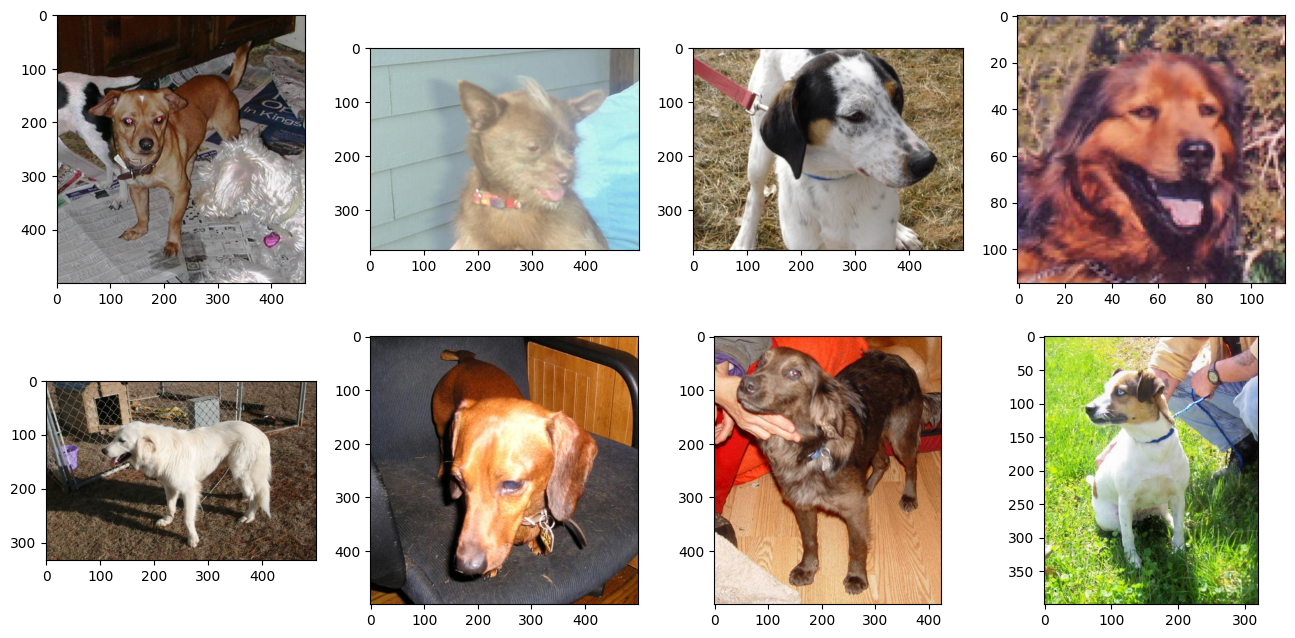

In [29]:
# ver las imagenes del dataset
def print_pictures(dir, fnames):
    nrows = 4
    ncols = 4

    pic_index = 0 # indice para iterar sobre las imagenes

    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    pic_index += 8

    next_pix = [os.path.join(dir, fname)
                for fname in fnames[pic_index-8:pic_index]
               ]
    for i, img_path in enumerate(next_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
    
    plt.show()


# Obtener archivos de cada categoría
cat_files = os.listdir(os.path.join(DATASET_DIR, "cat"))
dog_files = os.listdir(os.path.join(DATASET_DIR, "dog"))

# Mostrar los gatos y perros
print_pictures(os.path.join(DATASET_DIR, "cat"), cat_files)
print_pictures(os.path.join(DATASET_DIR, "dog"), dog_files)

# Preparación de los Datos:

### Dividimos el dataset en train, validation y test

In [30]:
# creamos train (50%), validation (25%) y test(25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y) # train

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # validation y test

# comprobarlo
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (1000, 224, 224, 3)
Forma de y_train: (1000,)
Forma de X_val: (500, 224, 224, 3)
Forma de y_val: (500,)
Forma de X_test: (500, 224, 224, 3)
Forma de y_test: (500,)


### Hacemos data augmentation para evitar [overfitting](https://en.wikipedia.org/wiki/Overfitting)

In [31]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train)

# Creación de la CNN

In [32]:
# creacion de nuestra red convolucional de reconocimiento de imagenes
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', # utiliza 32 filtros y se usan relus para tener siempre valores positivos
                 input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))) # X * Y * rgb
model.add(MaxPooling2D(2,2)) # reduce el tamaño a la mitad
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten()) # convierte la matriz a una sola dimension
model.add(Dense(512, activation='relu')) # 512 neuronas completamente conectadas
model.add(Dropout(0.5)) # Dropout para evitar overfitting
model.add(Dense(1, activation='sigmoid')) # función sigmoide para decir perro o gato, una sola neurona

model.summary()

/home/mike/Repos/cats-and-dogs/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

### Configuración de los hiperparámetros

In [33]:
# Configuración de los hiperparámetros

# Optimizador
model.compile(optimizer=RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['acc'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Guardar mejor modelo
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

### Entrenamiento del modelo

In [17]:
# Entrenar el modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - acc: 0.4738 - loss: 26.4696

2025-11-20 23:00:11.829008: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 301056000 exceeds 10% of free system memory.


31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 921ms/step - acc: 0.4876 - loss: 12.8976 - val_acc: 0.5040 - val_loss: 0.8195 - learning_rate: 1.0000e-04
Epoch 2/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 25s 854ms/step - acc: 0.5000 - loss: 1.1500

/home/mike/python/.venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - acc: 0.5000 - loss: 1.1500 - val_acc: 0.5080 - val_loss: 0.9529 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 914ms/step - acc: 0.5227 - loss: 0.8456 - val_acc: 0.5580 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - acc: 0.5938 - loss: 0.6607 - val_acc: 0.5600 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 908ms/step - acc: 0.5475 - loss: 0.7146 - val_acc: 0.5780 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.6250 - loss: 0.6021 - val_acc: 0.5820 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - acc: 0.5888 - loss: 0.6750 - val_acc: 0.5880 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.6562 - loss: 0.6136 - val_acc: 0.5900 - val_loss: 0.6734 - learning_rate:

### Visualización del comportamiento del entrenamiento

/tmp/ipykernel_60947/1851195969.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


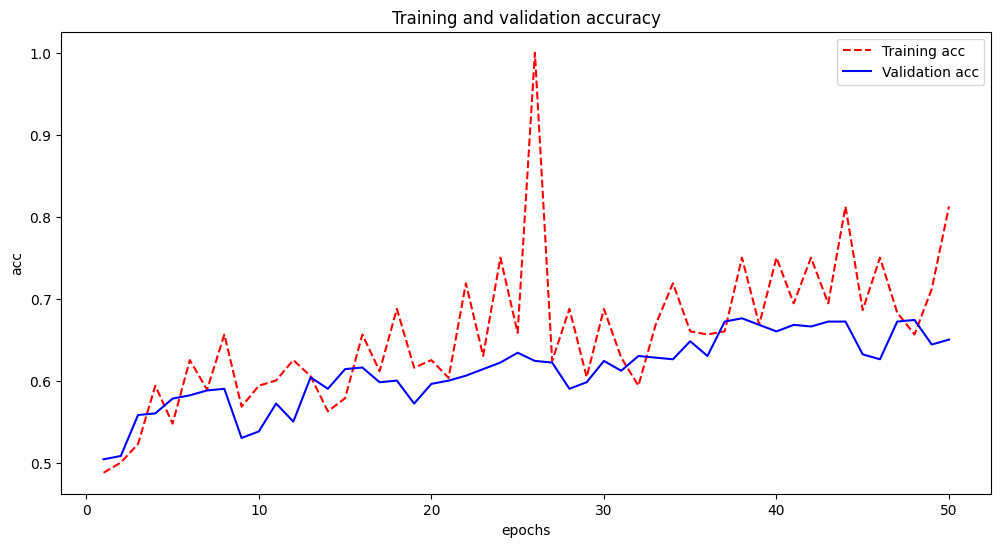

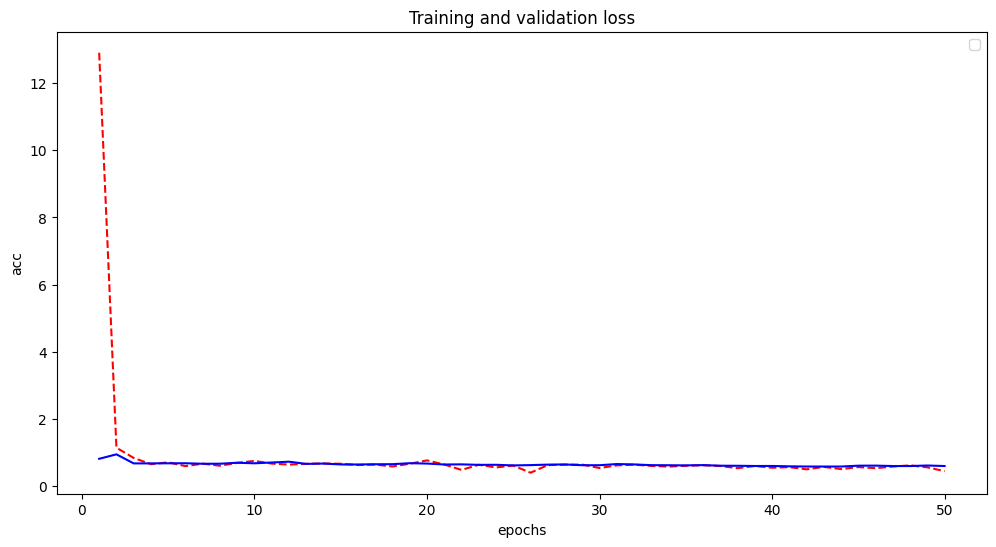

<Figure size 1200x600 with 0 Axes>

In [20]:
# Visualización del comportamiento del entrenamiento
acc0 = history.history['acc']
val_acc0 = history.history['val_acc']
loss0 = history.history['loss']
val_loss0 = history.history['val_loss']
epochs0 = range(1, len(acc)+1, 1)

def showAccuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'r--', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    
    plt.legend()
    plt.figure()


def showLoss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'r--')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    
    plt.legend()
    plt.figure()

showAccuracy(epochs0, acc0, val_acc0)
showLoss(epochs0, loss0, val_loss0)

En la primera gráfica se presenta la precisión obtenida en cada _epoch_, tanto para los datos de entrenamiento como para los de la validación. En la segunda gráfica vemos la evolución en cada _epoch_ de la _loss_ para los dos conjuntos de datos.

### Resultados con el test

In [21]:
# ver resultados con el test
test_lost0, test_acc0 = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: ", test_acc0)
print("Test loss: ", test_lost0)

2025-11-20 23:25:28.086787: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 301056000 exceeds 10% of free system memory.


Test accuracy:  0.6700000166893005
Test loss:  0.6252498626708984


### Veamos si mi gato es un gato o un perro

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción: [[0.48920053]]


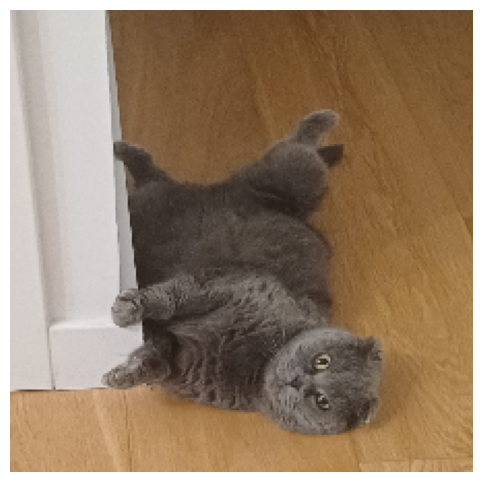

lupe.jpg IS A CAT


In [27]:
# Ahora veamos si mi gato es un gato o un perro
def isGuadalupeCat(modelo):
    path = 'lupe.jpg'
    img = image.load_img(path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    classes = modelo.predict(x)
    
    print("Predicción:", classes)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Decidir si es gato o perro
    if classes[0][0] > 0.5:
        print(path + " IS A DOG")
    else:
        print(path + " IS A CAT")


isGuadalupeCat(model)

# Transfer Learning
Ahora usaremos el concepto de [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) para entrenar nuevos y mejores modelos

## VGG16

### importar el modelo:

In [18]:
#importar el modelo
pre_trained_model = VGG16(input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3),
                          include_top = False,
                          weights = 'imagenet')
    
pre_trained_model.summary() # ver que se ha importado correctamente

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

###  Congelar capas para evitar que sus pesos se actualicen durante el entrenamiento:

In [20]:
for layer in pre_trained_model.layers:
    layer.trainable = False

### Añadimos el modelo importado a un modelo secuencial como si fuera una capa

In [43]:
modelFE0 = Sequential()
modelFE0.add(pre_trained_model)
modelFE0.add(Flatten())
modelFE0.add(Dense(256, activation='relu'))
modelFE0.add(Dense(1, activation='sigmoid')) # perro o gato
# (no hago finetuning porque daría lugar a overfitting)

modelFE0.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Como se puede ver, la base convolucional de VGG16 tiene $14714688$ parámetros, que es un número muy grande. Pero fijémonos en que ahora no se entrenan estos parámetros (está indicado en la última línea con la etiqueta `Non-trainable params` que hasta ahora siempre la hemos visto a 0), y que el clasificador que estamos agregando en la parte final tiene 6 millones de parámetros que si son entrenables.

### Compilamos y entrenamos

In [35]:
# compilar
modelFE0.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(learning_rate=1e-4),
                 metrics=['acc'])

In [36]:
# entrenar
historyFE0 = modelFE0.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 7, 7, 1)

### Visualización del entrenamiento:

In [37]:
# Visualización del comportamiento del entrenamiento
acc1 = historyFE0.history['acc']
val_acc1 = historyFE0.history['val_acc']
loss1 = historyFE0.history['loss']
val_loss1 = historyFE0.history['val_loss']
epochs1 = range(1, len(acc)+1, 1)

showAccuracy(epochs1, acc1, val_acc1)
showLoss(epochs1, loss1, val_loss1)

NameError: name 'historyFE0' is not defined

### resultados con el Test

In [ ]:
# ver resultados con el test
test_lost1, test_acc1 = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: ", test_acc1)
print("Test loss: ", test_lost1)

### ¿Es mi gato un gato?

In [38]:
isGuadalupeCat(modelFE0)

NameError: name 'isGuadalupeCat' is not defined

### comparación con el CNN:

In [ ]:
proporcionAcc = test_acc1/test_acc0
proporcionLoss = test_lost1/test_lost0
print("El TTL es ", proporcionAcc, " veces más preciso")
print("El TTL tiene ", proporcionLoss, " veces más loss")

# Conclusiones